In [55]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler

In [56]:
# Load the datasets
test = pd.read_csv('test_metadata.csv')
train = pd.read_csv('train-metadata.csv')

/var/folders/1y/hw6xl16s53v1zm41lc7jvwmw0000gn/T/ipykernel_1799/288242735.py:3: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('train-metadata.csv')


In [57]:
# Save the patients and targets to use later for the split 
patients = train['patient_id']
targets = train['target']

In [69]:
patients.head()

0    IP_1235828
1    IP_8170065
2    IP_6724798
3    IP_4111386
4    IP_8313778
Name: patient_id, dtype: object

In [58]:
# Convert each patient ID to a unique integer
new_patients, _ = pd.factorize(patients)

In [59]:
# Keep the test numerical features only
columns = list(test.columns)
train = train[columns].select_dtypes(include=['number'])

In [60]:
#train['patient_id'] = new_patients

In [61]:
len(train['patient_id'].unique())

1042

In [68]:
train.shape

(401059, 35)

In [62]:
train.columns

Index(['age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext',
       'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H',
       'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'patient_id'],
      dtype='object')

In [63]:
# Fill missing values with zeros
train_filled = train.fillna(0)

In [65]:
# Split the data to 85 15 by patients, while keeping the target distributed properly
gss = GroupShuffleSplit(n_splits=1, train_size=0.85, random_state=42)
train_idx, test_idx = next(gss.split(train_filled, groups=patients, y=targets))   

x_train, x_test = train_filled.iloc[train_idx], train_filled.iloc[test_idx]
x_test = x_test.drop(columns=['patient_id'])
y_train, y_test = [targets[i] for i in train_idx], [targets[i] for i in test_idx]

# Validate the split 
data_size = train_filled.shape[0]
training_size = x_train.shape[0]
# assert training_size * 100 / data_size <= 85 and training_size * 100 / data_size >=70, f'training percentage is {training_size * 100 / data_size}'

positive_size = 393
training_positive_size = sum(y_train)
# assert training_positive_size * 100 / positive_size <=85 and training_positive_size * 100 / positive_size >= 70, f'training positive percentage is {training_positive_size*100 / positive_size}'

# Verify the split
print(f'Data split: {training_size * 100 / data_size}, {100 - (training_size * 100 / data_size)}')
print(f'Positives cases split: {training_positive_size*100 / positive_size}, {100 - (training_positive_size*100 / positive_size) }')


Data split: 84.60401088119204, 15.395989118807961
Positives cases split: 85.49618320610686, 14.503816793893137


In [66]:
x_train.shape

(339312, 35)

In [67]:
x_train.columns

Index(['age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext',
       'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H',
       'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'patient_id'],
      dtype='object')

In [18]:
# Calculate number of negatives in training set 
x_train.shape[0] - 336

338976

In [19]:
# Number of patients in training set 
len(x_train['patient_id'].unique())

885

In [20]:
# Number of positive cases in training set
sum(y_train)

336

In [21]:
 # Define the function to calculate the AUC
def calculate_auc(y_test, y_pred):
    fpr, tpr, thresholds= roc_curve(y_test, y_pred)
    new_tpr = []
    for num in tpr:
        if num>=0.8:
            new_tpr.append(0.8)
        else:
            new_tpr.append(num)    
    return auc(fpr,tpr)-auc(fpr,new_tpr)

In [22]:
# Function for near miss under sampling 
def undersampling(x_train, y_train, sampling_strategy):
    # define the under-sampling method
    undersample = NearMiss(version=1, n_neighbors_ver3=3, sampling_strategy=sampling_strategy)
    # transform the dataset
    x_train_final, y_train_final = undersample.fit_resample(x_train, y_train)
    # drop the patient ids 
    x_train_final = x_train_final.drop(columns=['patient_id'])
    return x_train_final, y_train_final

In [23]:
# Create, train and evaluate lr model
def lr_model_performance(x_train, y_train, x_test, y_test):
    lr_model = LogisticRegression(class_weight='balanced', max_iter=2000)
    lr_model.fit(x_train, y_train)
    predictions = lr_model.predict_proba(x_test)[:, 1]
    
    return calculate_auc(y_test, predictions)

In [24]:
# Create, train and evaluate xgb model
def xgb_model_performance(x_train, y_train, x_test, y_test):    
    # Configure and train the xg-boost model  
    xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)
    xgb_model.fit(x_train, y_train)
    predictions = xgb_model.predict_proba(x_test)[:, 1]
    return calculate_auc(y_test, predictions)

In [15]:
# Define the number of negatives in each iteration 
num_of_positives = sum(y_train)
sampling_strategy_list = [{0:num_of_positives, 1:num_of_positives},{0:1_000, 1:num_of_positives},{0:10_000, 1:num_of_positives}, {0:100_000, 1:num_of_positives}, {0:200_000, 1:num_of_positives}, {0:338976, 1:num_of_positives}]

In [29]:
# Initiate lists for scores and graphs
lr_scores = []
xgboost_scores = []
graph_x_axis = [dict[0] for dict in sampling_strategy_list]

In [31]:
# Train models on each of the near miss undersampling, and save the scores 
for dictionary in sampling_strategy_list:
    # Define the under-sampling method
    x, y = undersampling(x_train, y_train, dictionary)
    # Calculate score for each model, and add it to the lists
    lr_scores.append(lr_model_performance(x, y, x_test, y_test))
    xgboost_scores.append(xgb_model_performance(x, y, x_test, y_test))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [32]:
lr_scores

[0.05214664152681925,
 0.053621759049918394,
 0.08140817272554046,
 0.12021806827004289,
 0.1316941811490958,
 0.1443484542122041]

In [33]:
xgboost_scores

[0.0750033699908712,
 0.0915556276003674,
 0.11991940460650741,
 0.14536229534770617,
 0.14034917086849052,
 0.15338344239590707]

In [157]:
# Function for K-means undersampling
def kmeans_undersampling(x, y, strategy):
    undersample = ClusterCentroids(sampling_strategy=strategy)
    x_res, y_res = undersample.fit_resample(x, y)
    x_res = x_res.drop(columns=['patient_id'])
    return x_res, y_res

In [ ]:
# loop for running the k-means undersamplings (run in kaggle cloud)
for dictionary in sampling_strategy_list:
    x, y = kmeans_undersampling(x_train, y_train, dictionary)
    lr_scores.append(lr_model_performance(x, y, x_test, y_test))
    xgboost_scores.append(xgb_model_performance(x, y, x_test, y_test))

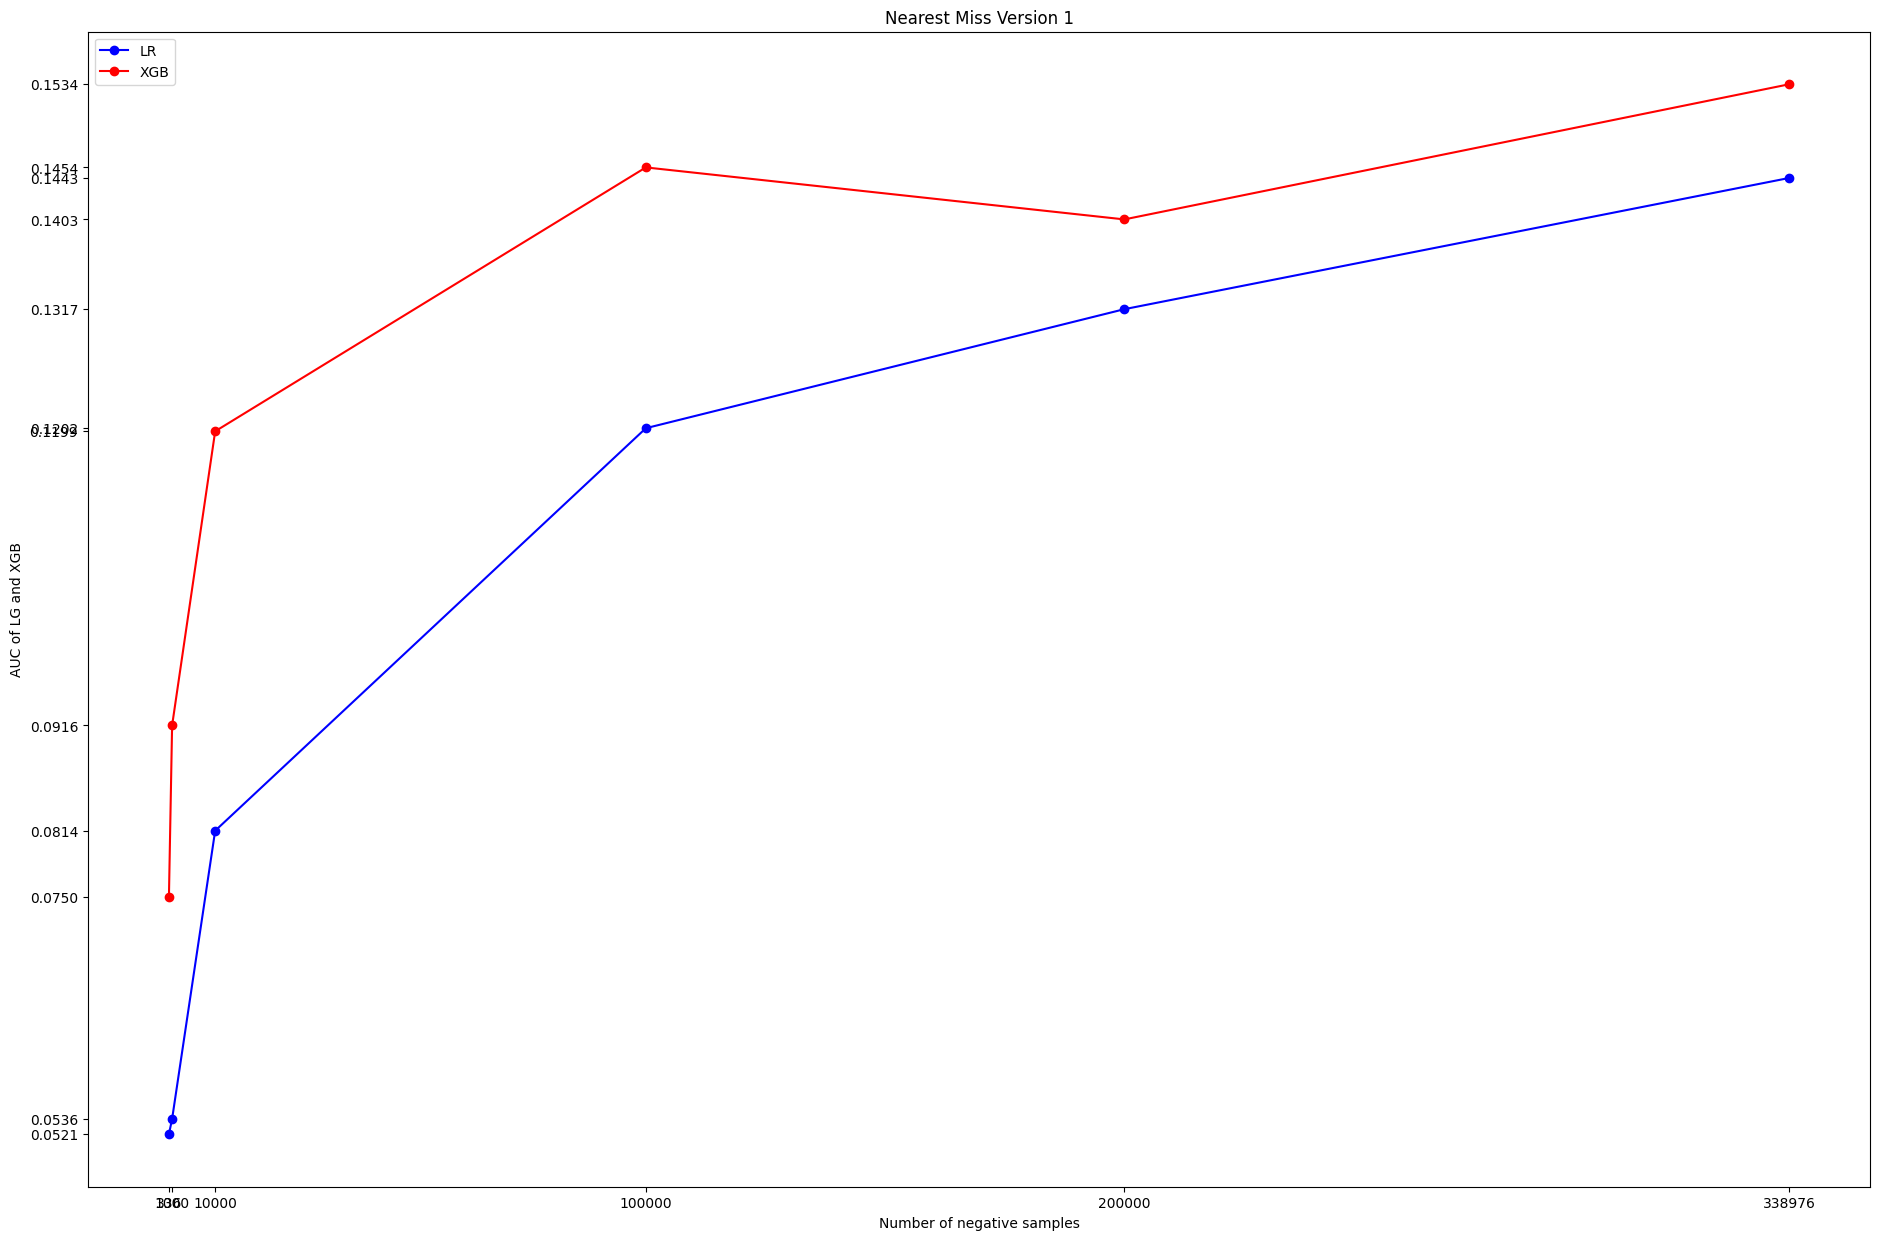

In [34]:
# plot graph for scores of near miss strategy
x = graph_x_axis
y1 = lr_scores
y2 = xgboost_scores

# Create the plot
plt.figure(figsize=(23, 15))
plt.plot(x, y1, label='LR', color='blue', marker='o')
plt.plot(x, y2, label='XGB', color='red', marker='o')

# Add titles and labels
plt.title('Nearest Miss Version 1')
plt.xlabel('Number of negative samples')
plt.ylabel('AUC of LG and XGB')
plt.legend()

# Set x-axis ticks to match x array
plt.xticks(x)
plt.yticks(y1 + y2)

# Show the plot
plt.show()

In [53]:
# scores for k-means strategy - ran in kaggle cloud 
km_lr_scores = [0.14202950235046186, 0.14070459826011772, 0.13180094018479493, 0, 0, 0]
km_xgb_scores = [0.12593394249117684, 0.11792877801571522, 0.11021107233962679, 0, 0, 0]
km_x_axis = [336, 1_000, 10_000]

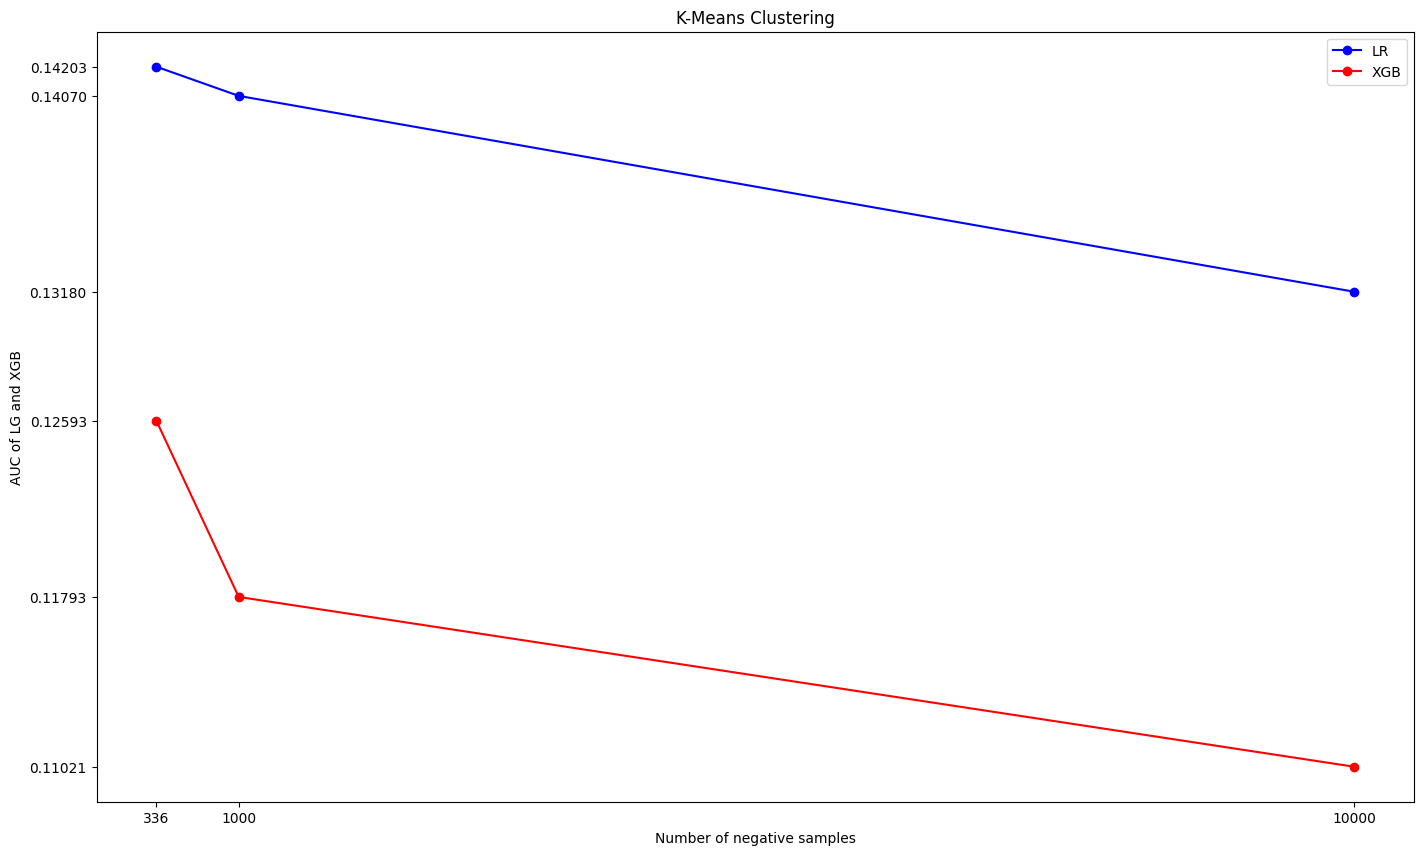

In [187]:
# Create the plot for the k-means strategy
plt.figure(figsize=(17, 10))
plt.plot(km_x_axis, km_lr_scores, label='LR', color='blue', marker='o')
plt.plot(km_x_axis, km_xgb_scores, label='XGB', color='red', marker='o')

# Add titles and labels
plt.title('K-Means Clustering')
plt.xlabel('Number of negative samples')
plt.ylabel('AUC of LG and XGB')
plt.legend()

# Set x-axis ticks to match x array
plt.xticks(km_x_axis)
plt.yticks(km_lr_scores + km_xgb_scores)

# Show the plot
plt.show()

In [45]:
# Function for random under sampling strategy
def random_undersampling(x_train,y_train,sampling_strategy):
    # transform the dataset
    rus = RandomUnderSampler(random_state=42,sampling_strategy = sampling_strategy)
    x_new_train, y_new_train = rus.fit_resample(x_train, y_train)
    # drop the patient id before training
    x_new_train = x_new_train.drop(columns=["patient_id"])
    return x_new_train,y_new_train

In [46]:
random_lr_scores = []
random_xgb_scores = []

In [47]:
# Train models on each of the random undersampling, and save the scores 
for dictionary in sampling_strategy_list:
    # Define the under-sampling method
    x, y = random_undersampling(x_train, y_train, dictionary)
    # Calculate score for each model, and add it to the lists
    random_lr_scores.append(lr_model_performance(x, y, x_test, y_test))
    random_xgb_scores.append(xgb_model_performance(x, y, x_test, y_test))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [48]:
random_lr_scores

[0.14227561121965215,
 0.1449057397912028,
 0.14501579772091933,
 0.14609840373343796,
 0.14468164250795568,
 0.14503098400889547]

In [49]:
random_xgb_scores

[0.14342527578469588,
 0.1513885784326272,
 0.1520044478191751,
 0.14473778058373343,
 0.15117844457147067,
 0.14551978909829266]

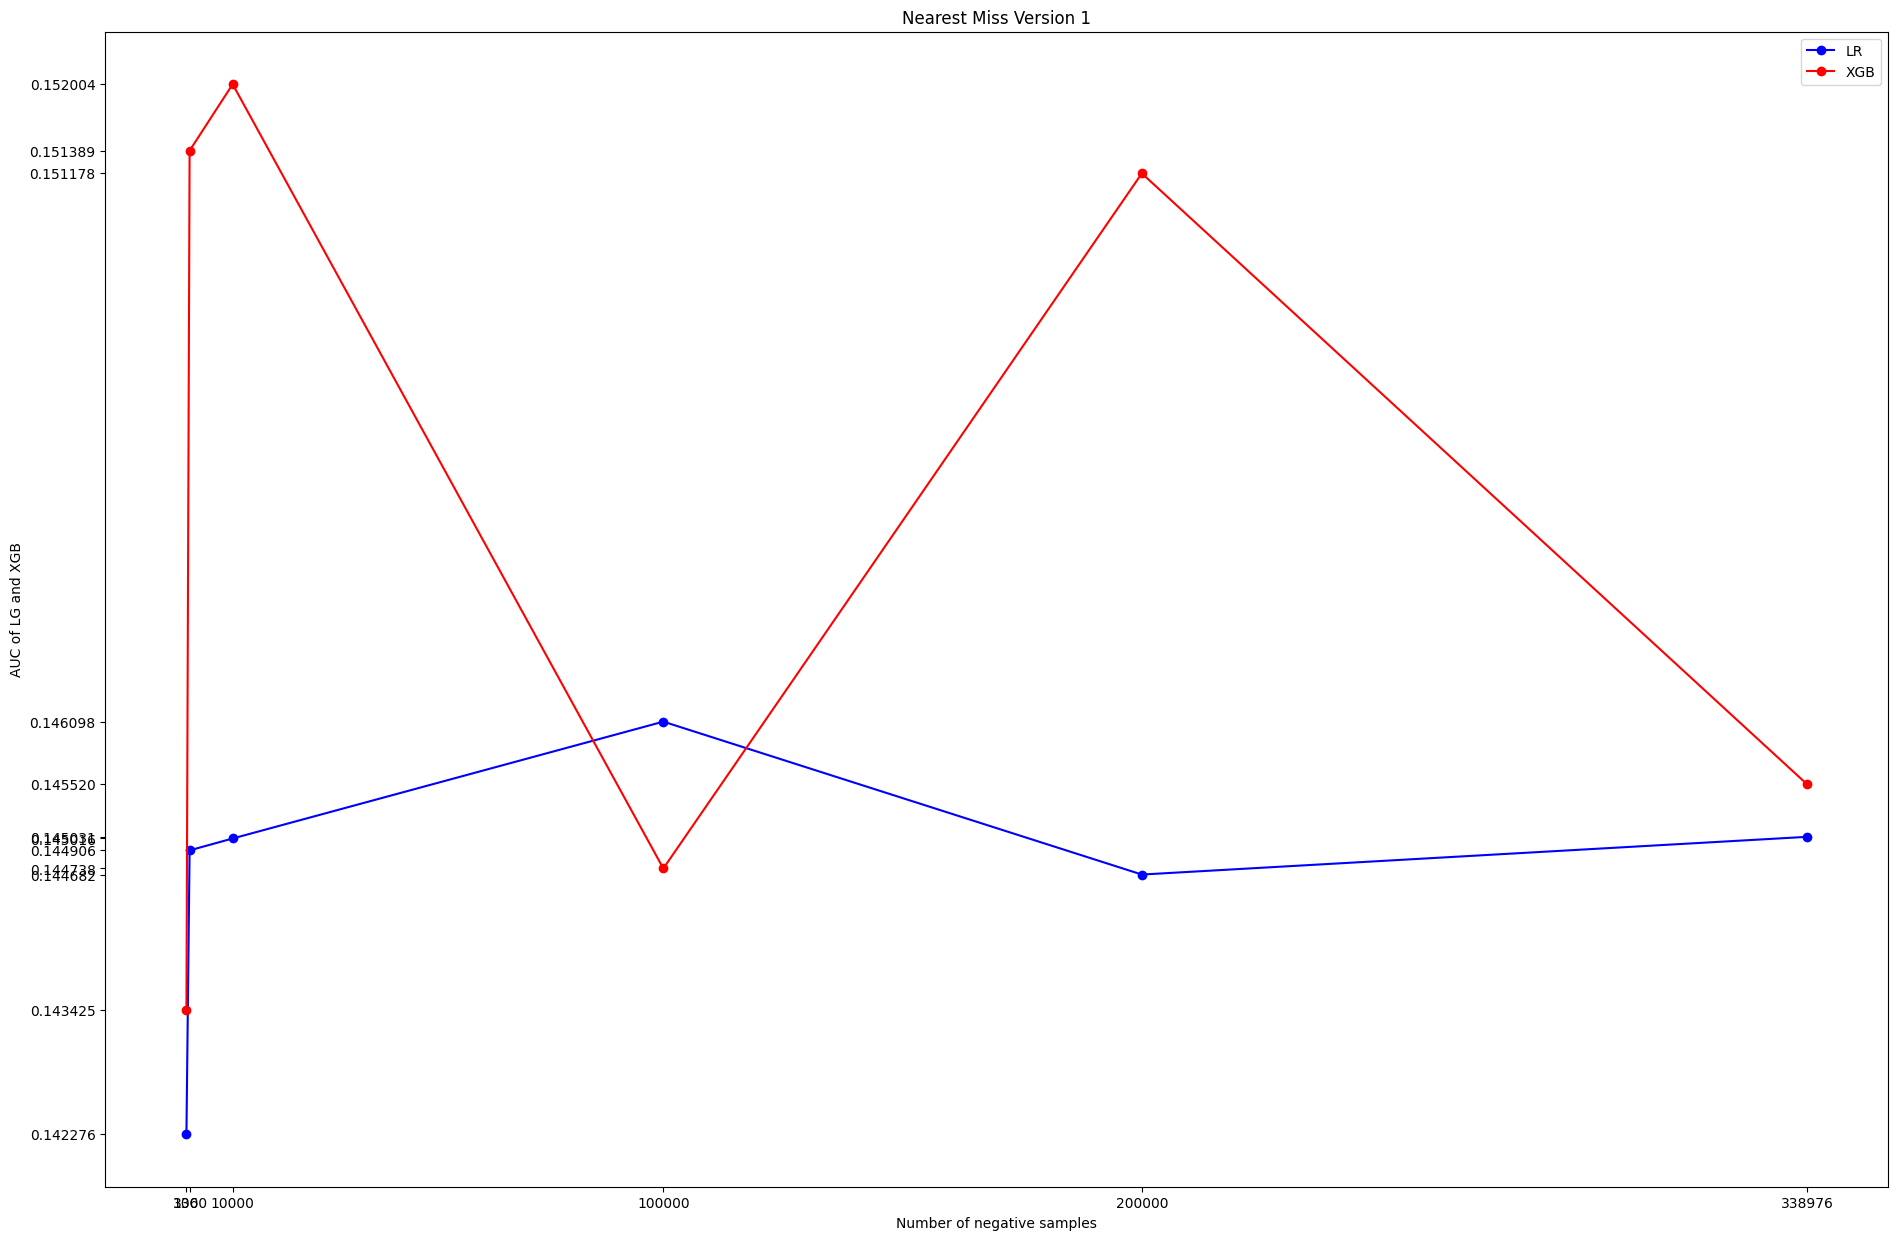

In [50]:
# plot graph for scores of random strategy
x = graph_x_axis
y1 = random_lr_scores
y2 = random_xgb_scores

# Create the plot
plt.figure(figsize=(23, 15))
plt.plot(x, y1, label='LR', color='blue', marker='o')
plt.plot(x, y2, label='XGB', color='red', marker='o')

# Add titles and labels
plt.title('Nearest Miss Version 1')
plt.xlabel('Number of negative samples')
plt.ylabel('AUC of LG and XGB')
plt.legend()

# Set x-axis ticks to match x array
plt.xticks(x)
plt.yticks(y1 + y2)

# Show the plot
plt.show()

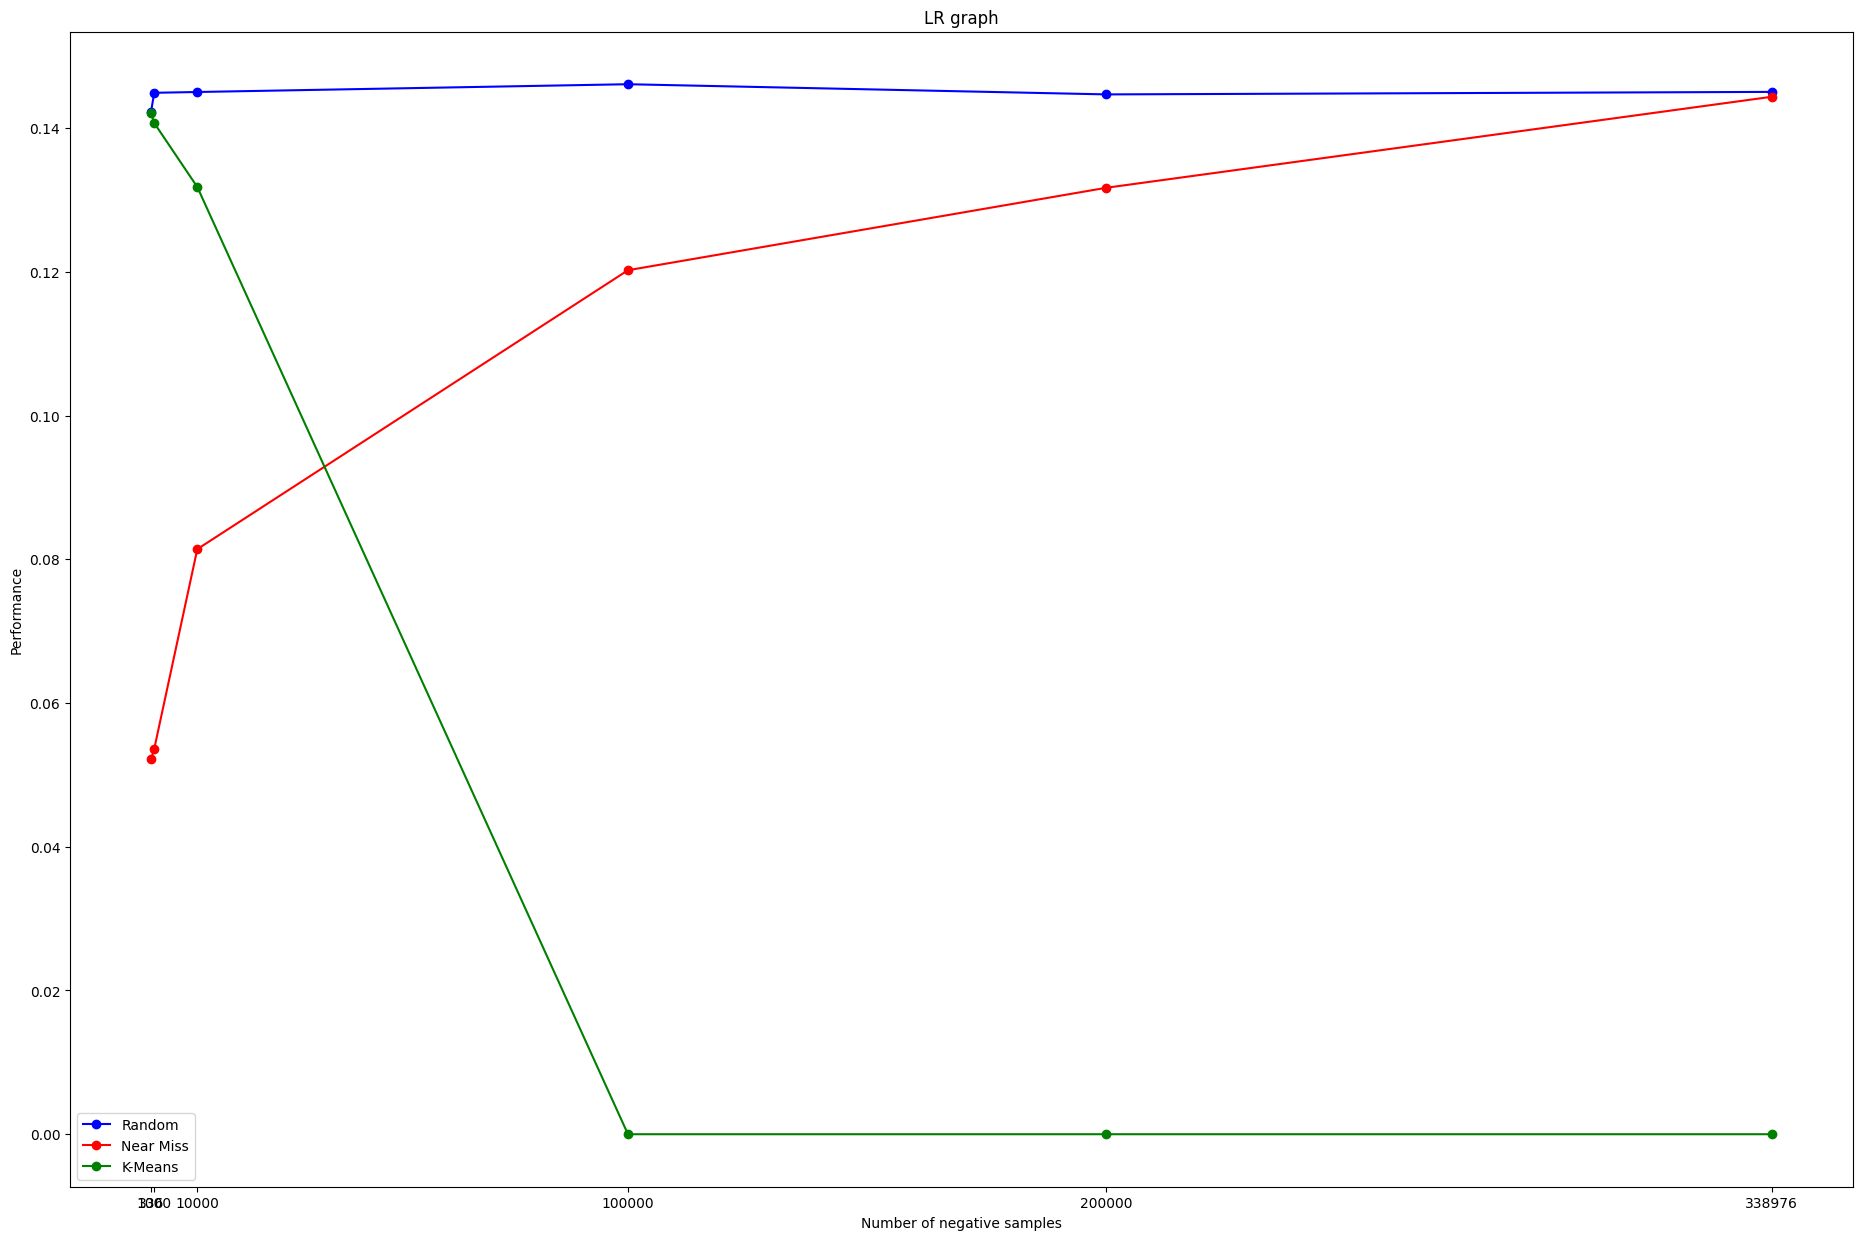

In [51]:
# Create LR graph
x = graph_x_axis
y1 = random_lr_scores
y2 = lr_scores
y3 = km_lr_scores

# Create the plot
plt.figure(figsize=(23, 15))
plt.plot(x, y1, label='Random', color='blue', marker='o')
plt.plot(x, y2, label='Near Miss', color='red', marker='o')
plt.plot(x, y3, label='K-Means', color='green', marker='o')

# Add titles and labels
plt.title('LR graph')
plt.xlabel('Number of negative samples')
plt.ylabel('Performance')
plt.legend()

# Set x-axis ticks to match x array
plt.xticks(x)

# Show the plot
plt.show()

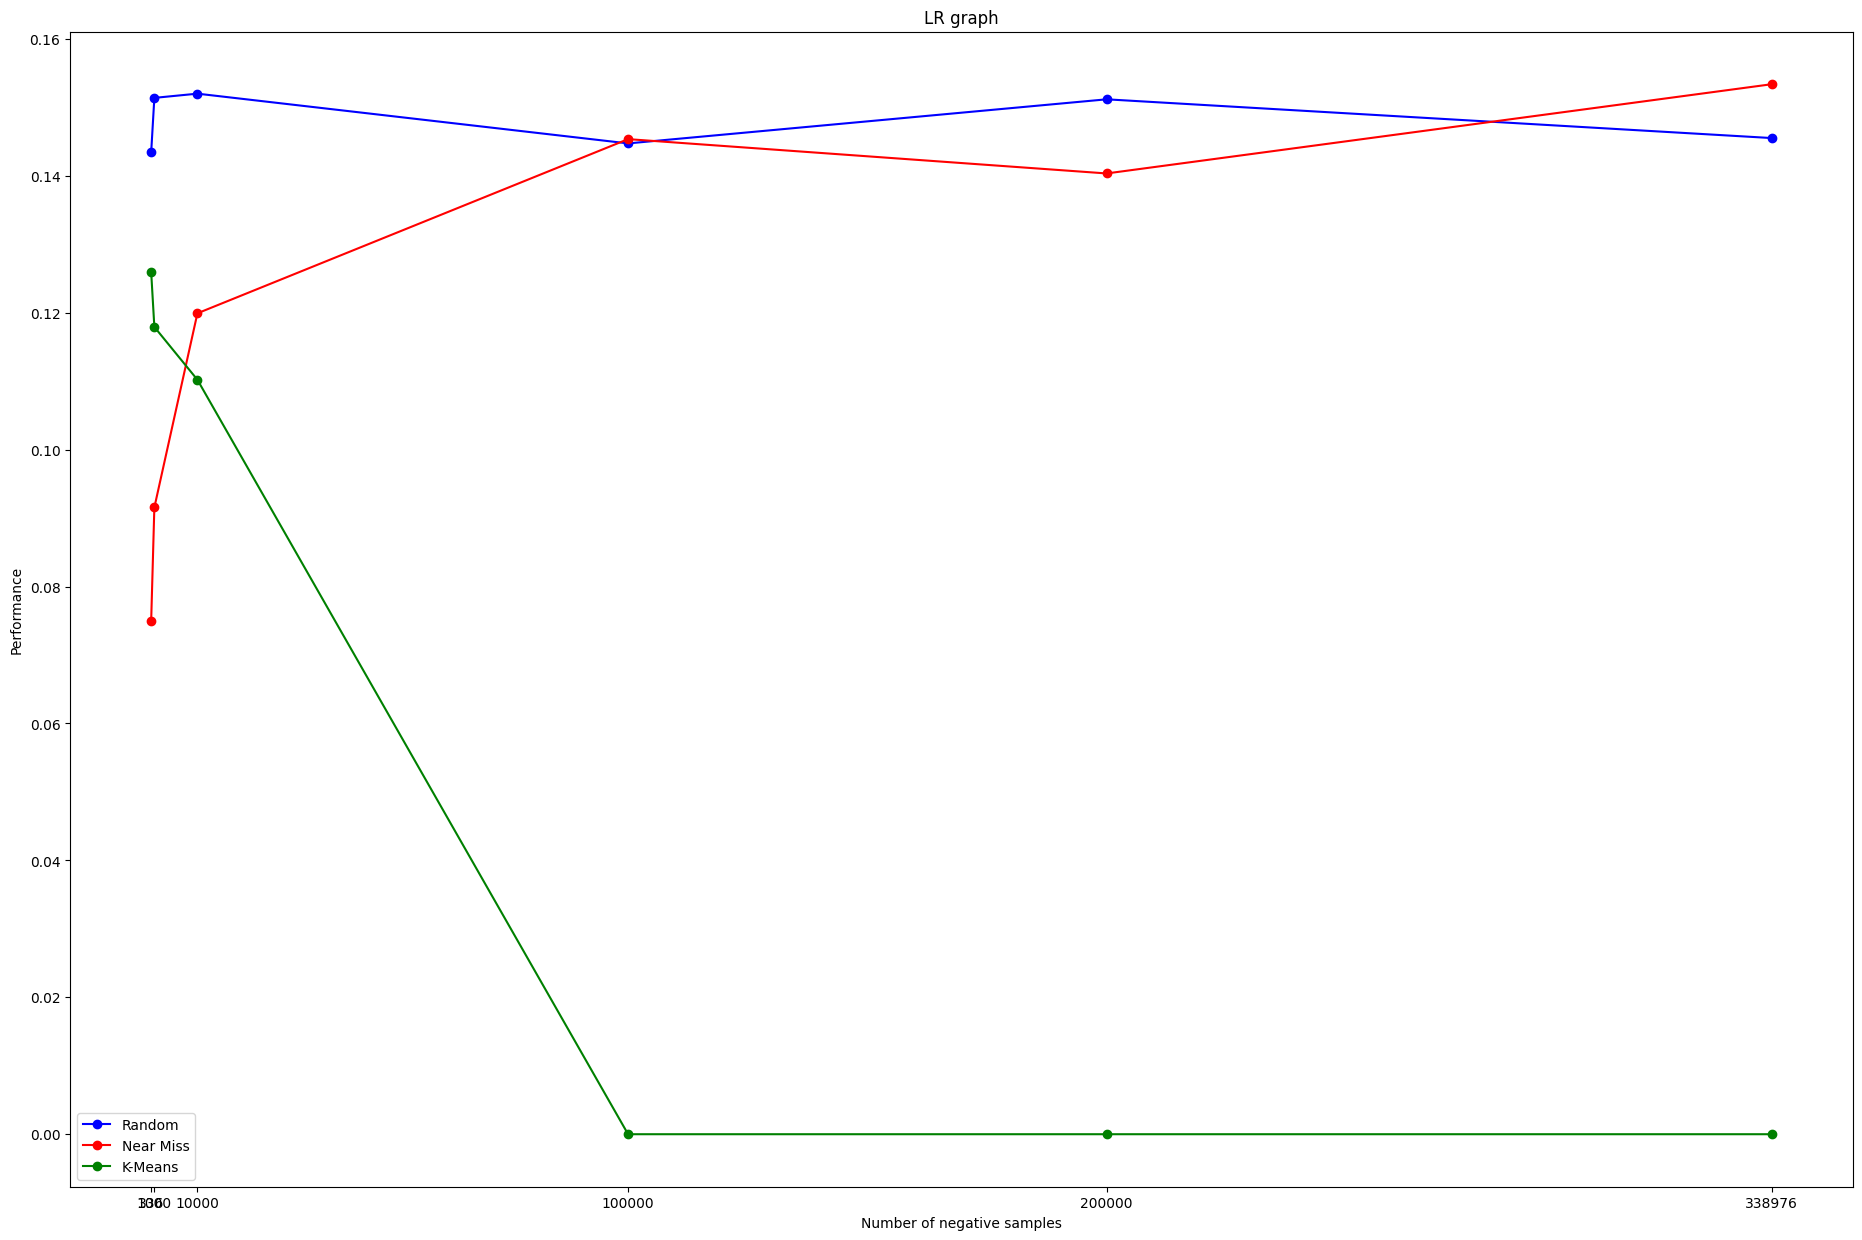

In [54]:
# Create XGB graph
x = graph_x_axis
y1 = random_xgb_scores
y2 = xgboost_scores
y3 = km_xgb_scores

# Create the plot
plt.figure(figsize=(23, 15))
plt.plot(x, y1, label='Random', color='blue', marker='o')
plt.plot(x, y2, label='Near Miss', color='red', marker='o')
plt.plot(x, y3, label='K-Means', color='green', marker='o')

# Add titles and labels
plt.title('LR graph')
plt.xlabel('Number of negative samples')
plt.ylabel('Performance')
plt.legend()

# Set x-axis ticks to match x array
plt.xticks(x)

# Show the plot
plt.show()